In [1]:
import numpy as np
from numpy.linalg import inv as inv
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Activation
from sklearn.preprocessing import MinMaxScaler
import time

from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import GradientBoostingRegressor

### Load the Seattle speed data set
Guangzhou speed dataset is stored in a 323 by 17568 matrix.
- **323** stands for 214 different road segments in Guangzhou.
- **17568** stands for 17568 time slots over two months. (5 min a time slot)

In [2]:
directory = '../datasets/Seattle_loop-data-set/'
ADJ = np.load( directory + 'Loop_Seattle_2015_A.npy')
dense_mat = np.load( directory + 'dense_mat.npy')
print('Adjacency matrix shape:')
print(ADJ.shape)
print()
print('Dataset shape:')
print(dense_mat.shape)

# The Seattle Traffic Speed dataset consists of speed data collected by 323 loop sensors 
# located in Seattle from 1st Nov, 2015 to 31th Dec, 2015.

Adjacency matrix shape:
(323, 323)

Dataset shape:
(323, 17568)


In [3]:
data = dense_mat[:].T
data.shape

(17568, 323)

In [4]:
17568 / 288

61.0

In [5]:
test_rate = 0.082

train_len = int((1 - test_rate) * dense_mat.shape[1])
print(train_len)
test_len = dense_mat.shape[1] - train_len
print(test_len)

16127
1441


In [4]:
1441 / (12*24)

5.003472222222222

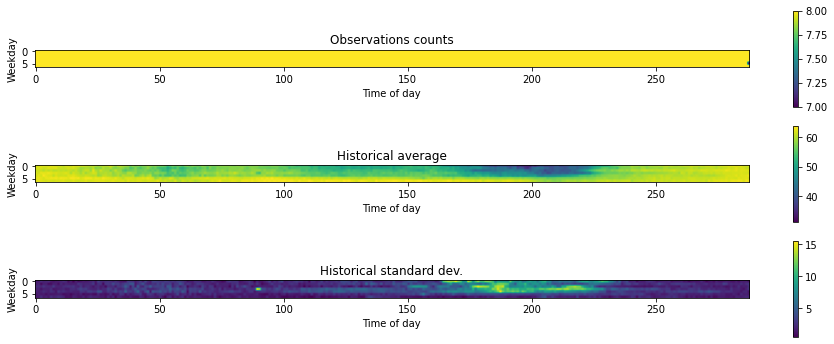

In [6]:
import sys, os
sys.path.append(os.path.abspath("/home/rodr/code/mobility-baselines"))
from mobility_detrender import MobilityDetrender
from evaluation import evaluation
import datetime

detrender = MobilityDetrender(day_duration=12*24, week_duration=7)
detrender.fit(data[:train_len], start_date=datetime.date(2015,11,1), holidays=[])
detrender.visualize(0)

In [7]:
detrended_data = detrender.transform(data, start_date=datetime.date(2015,11,1), holidays=[], mode='avg')
evl_train = evaluation(data, detrender.ha_trend)
print('Residuals of Historical Average (on all data) -> MAPE: %.3f; MAE:  %.3f; RMSE: %.3f' % tuple(evl_train)) 
detrended_data.shape

Residuals of Historical Average (on all data) -> MAPE: 0.151; MAE:  4.804; RMSE: 7.892


(17568, 323)

In [8]:
dense_mat.shape, detrender.ha_trend.shape

((323, 17568), (17568, 323))

In [9]:
# train/val/test split
training_ground_truth = dense_mat[:,:train_len].T
test_ground_truth = dense_mat[:,train_len:].T

training_ha = detrender.ha_trend[:train_len,:]
test_ha = detrender.ha_trend[train_len:,:]

print(training_ground_truth.shape, test_ground_truth.shape)
print(training_ha.shape, test_ha.shape)

(16127, 323) (1441, 323)
(16127, 323) (1441, 323)


In [10]:
def create_lstm_samples(dataset, time_lags, rate):
    dataX, dataY = [], []
    data_len = dataset.shape[0] - np.max(time_lags)
    
    for t in range(data_len):
        a = dataset[t + np.max(time_lags) - time_lags, :][::-1]
        dataX.append(a)
        dataY.append(dataset[t + np.max(time_lags), :])
    return np.array(dataX), np.array(dataY)

x_train, y_train = create_lstm_samples(training_ground_truth, range(1,11), 1)
x_test, y_test = create_lstm_samples(test_ground_truth, range(1,11), 1)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

x_train_ha, y_train_ha = create_lstm_samples(training_ha, range(1,11), 1)
x_test_ha, y_test_ha = create_lstm_samples(test_ha, range(1,11), 1)
print(x_train_ha.shape, y_train_ha.shape)
print(x_test_ha.shape, y_test_ha.shape)

(16117, 10, 323) (16117, 323)
(1431, 10, 323) (1431, 323)
(16117, 10, 323) (16117, 323)
(1431, 10, 323) (1431, 323)


In [11]:
evl_test = evaluation(y_test, y_test_ha)
print('Test set -> MAPE: %.3f; MAE:  %.3f; RMSE: %.3f' % tuple(evl_test)) 

Test set -> MAPE: 0.125; MAE:  6.025; RMSE: 9.821


In [12]:
def mean_absolute_percentage_error(y_true, y_pred, pos): 
    return np.mean(np.abs((y_true[pos] - y_pred[pos]) / y_true[pos])) * 100
def root_mean_squared_error(y_true, y_pred, pos): 
    return np.sqrt(np.mean(np.square(y_true[pos] - y_pred[pos])))

pos = np.where(y_test != 0)
testPred_rmse = root_mean_squared_error(y_test, y_test_ha, pos)
print('Test prediction RMSE: %.2f RMSE' % (testPred_rmse))
testPred_mape = mean_absolute_percentage_error(y_test, y_test_ha, pos)
print('Test prediction MAPE: %.2f%% MAPE' % (testPred_mape))

Test prediction RMSE: 9.82 RMSE
Test prediction MAPE: 12.54% MAPE


In [19]:
# 1-step ahead prediction

all_preds = []
all_trues = []
for loc in range(x_train.shape[2]):
    # prepare input data
    x = x_train[:, :, loc] - x_train_ha[:, :, loc] # detrend input data for training
    y = y_train[:, loc] - y_train_ha[:, loc] # detrend targets for training
    
    # fit ML models
    reg = LinearRegression()
    reg.fit(x, y)
    
    # predict on test set
    trues = y_test[:, loc] # targets for test set (i.e., actual observations w/o detrending)
    preds = reg.predict(x_test[:, :, loc] - x_test_ha[:, :, loc]) # make predictions on detrended inputs
    preds = preds + y_test_ha[:, loc] # convert preds back to original scale (revert detrending)
    all_preds.append(preds)
    all_trues.append(trues)
    
all_preds = np.array(all_preds).T
print(all_preds.shape)
all_trues = np.array(all_trues).T
print(all_trues.shape)

evl_test = evaluation(all_trues, all_preds)
print('Test set -> MAPE: %.3f; MAE:  %.3f; RMSE: %.3f' % tuple(evl_test)) 

(1431, 323)
(1431, 323)
Test set -> MAPE: 0.055; MAE:  2.700; RMSE: 3.951


In [20]:
pos = np.where(y_test != 0)
testPred_rmse = root_mean_squared_error(y_test, all_preds, pos)
print('Test prediction RMSE: %.2f RMSE' % (testPred_rmse))
testPred_mape = mean_absolute_percentage_error(y_test, all_preds, pos)
print('Test prediction MAPE: %.2f%% MAPE' % (testPred_mape))

Test prediction RMSE: 3.95 RMSE
Test prediction MAPE: 5.46% MAPE


In [18]:
# sanity check by having an empty model that predicts always zero - this is the same as predicting using HA only

all_preds = []
all_trues = []
for loc in range(x_train.shape[2]):
    # prepare input data
    x = x_train[:, :, loc] - x_train_ha[:, :, loc] # detrend input data for training
    y = y_train[:, loc] - y_train_ha[:, loc] # detrend targets for training
    
    # no ML model
    
    # predict on test set
    trues = y_test[:, loc] # targets for test set (i.e., actual observations w/o detrending)
    preds = 0 # prediction is always zero
    preds = preds + y_test_ha[:, loc] # convert preds back to original scale (revert detrending)
    all_preds.append(preds)
    all_trues.append(trues)
    
all_preds = np.array(all_preds).T
print(all_preds.shape)
all_trues = np.array(all_trues).T
print(all_trues.shape)

evl_test = evaluation(all_trues, all_preds)
print('Test set -> MAPE: %.3f; MAE:  %.3f; RMSE: %.3f' % tuple(evl_test)) 

(1431, 323)
(1431, 323)
Test set -> MAPE: 0.125; MAE:  6.025; RMSE: 9.821
